In [1]:
# imports:  
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
torch.manual_seed(0);

In [2]:
train_data = pd.read_csv('energy_train.csv')
test_data = pd.read_csv('energy_test.csv')

In [3]:
x_train = torch.tensor(train_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_train = torch.tensor(train_data[['W']].values).float()
x_test = torch.tensor(test_data[['F11','F12', 'F13','F21','F22','F23','F31','F32','F33']].values).float()
y_test = torch.tensor(test_data[['W']].values).float()

In [4]:
# Splitting x_train and y_train into 3 sets of 200 each
UT_x = x_train[:200]
UT_y = y_train[:200]

SS_x = x_train[200:400]
SS_y = y_train[200:400]

BT_x = x_train[400:600]
BT_y = y_train[400:600]

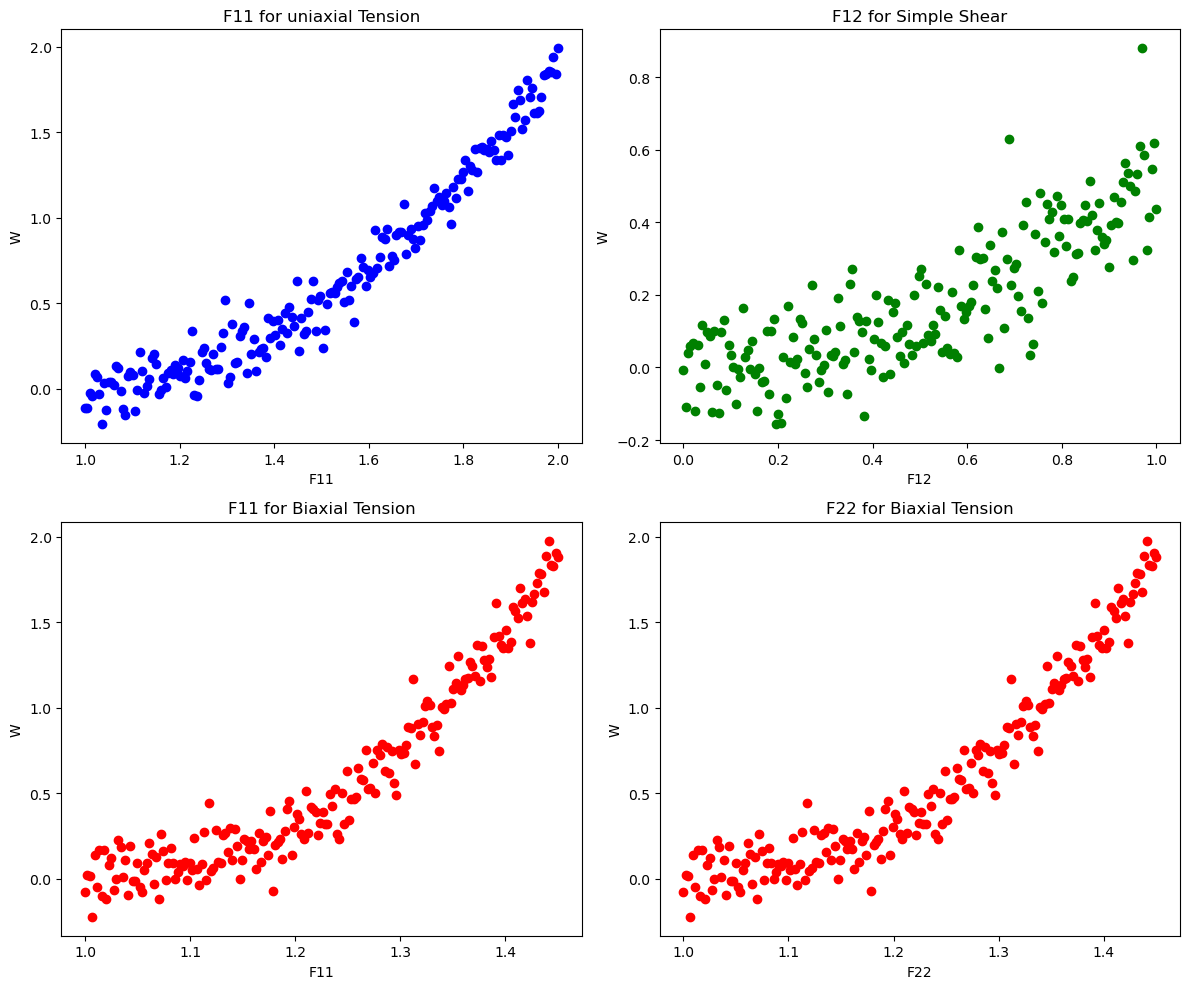

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot F11 for UT and BT against W
axes[0,0].scatter(UT_x[:, 0].numpy(), UT_y.numpy(), label='UT', color='blue')
axes[0,0].set_title('F11 for uniaxial Tension')
axes[0,0].set_xlabel('F11')
axes[0,0].set_ylabel('W')

# Plot F12 for SS against W
axes[0,1].scatter(SS_x[:, 1].numpy(), SS_y.numpy(), label='SS', color='green')
axes[0,1].set_title('F12 for Simple Shear')
axes[0,1].set_xlabel('F12')
axes[0,1].set_ylabel('W')

# Plot F11 for BT against W
axes[1,0].scatter(BT_x[:, 0].numpy(), BT_y.numpy(), label='BT', color='red')
axes[1,0].set_title('F11 for Biaxial Tension')
axes[1,0].set_xlabel('F11')
axes[1,0].set_ylabel('W')

# Plot F22 for BT against W
axes[1, 1].scatter(BT_x[:, 4].numpy(), BT_y.numpy(), label='BT', color='red')
axes[1, 1].set_title('F22 for Biaxial Tension')
axes[1, 1].set_xlabel('F22')
axes[1, 1].set_ylabel('W')

# Adjust layout
plt.tight_layout()
#plt.savefig('Train.png')

# Show the plots
plt.show()

### TRIAL

In [6]:
class convexLinear(nn.Module):
	def __init__(self, size_in, size_out):
		super().__init__()
		self.size_in, self.size_out = size_in, size_out
		weights = torch.Tensor(size_out, size_in)
		self.weights = nn.Parameter(weights)

		nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5))

	def forward(self, x):
		w_times_x= torch.mm(x, F.softplus(self.weights.t()))
		return w_times_x

In [7]:
class ICNN(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(ICNN, self).__init__()
        # Create Module dicts for the hidden and skip-connection layers
        self.layers = nn.ModuleDict()
        self.depth = len(n_hidden)
        self.layers[str(0)] = nn.Linear(n_input, n_hidden[0]).float()
        nn.init.xavier_uniform_(self.layers[str(0)].weight)
        # Create create NN with number of elements in n_hidden as depth
        for i in range(1, self.depth):
            self.layers[str(i)] = convexLinear(n_hidden[i-1], n_hidden[i]).float()

        self.layers[str(self.depth)] = convexLinear(n_hidden[self.depth-1], n_output).float()
        
    def forward(self, x):
        # First layer
        x = x.view(-1, 3, 3)
        det = torch.det(x)
        det = det.view(-1, 1)
        x_t = x.transpose(1, 2)
        mult = torch.bmm(x_t, x)
        trace = torch.diagonal(mult, dim1=1, dim2=2).sum(1)
        trace = trace.view(-1, 1)
        x = torch.cat((trace, det), 1)
        z = x.clone()
        z = self.layers[str(0)](z)

        for layer in range(1, self.depth):
            z = self.layers[str(layer)](z)
            z = F.softplus(z)
            z = torch.square(z)
        y = self.layers[str(self.depth)](z)
        return y


In [8]:
n_input = 2
n_output = 1
n_hidden = [64, 64]
icnn = ICNN(n_input, n_hidden, n_output)

print(icnn)

ICNN(
  (layers): ModuleDict(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): convexLinear()
    (2): convexLinear()
  )
)


In [9]:
# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

# Learning rate
lr = 0.0005

# Optimizer: use Adam
optimizer = torch.optim.Adam(icnn.parameters(), lr=lr)

# Loss function: use the MEAN SQUARED ERROR (MSE) as loss
loss_function = nn.MSELoss()

# number of steps, the proper term is 'EPOCH'
num_epochs = 10000

# begin iterating over epochs
for epoch in range(num_epochs):
    
    # Make your predictions, USE TRAINING DATA ONLY!!
    y_train_pred = icnn(x_train)
    # Compute the loss.
    train_loss = loss_function(y_train_pred, y_train)
    
    # Store the loss in a list
    train_loss_history.append(train_loss.item())
    
    # Zero gradients, backward pass, and update weights
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # We also track the loss on test data but don't use that information for training (just for monitoring purpose)
    with torch.no_grad():
        # Make your predictions
        y_test_pred = icnn(x_test)
        
        # Compute the loss.
        test_loss = loss_function(y_test_pred, y_test)
        
        # Store the loss in a list
        test_loss_history.append(test_loss.item())

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')

Epoch [1/10000]
Epoch [1001/10000]
Epoch [2001/10000]
Epoch [3001/10000]
Epoch [4001/10000]
Epoch [5001/10000]
Epoch [6001/10000]
Epoch [7001/10000]
Epoch [8001/10000]
Epoch [9001/10000]


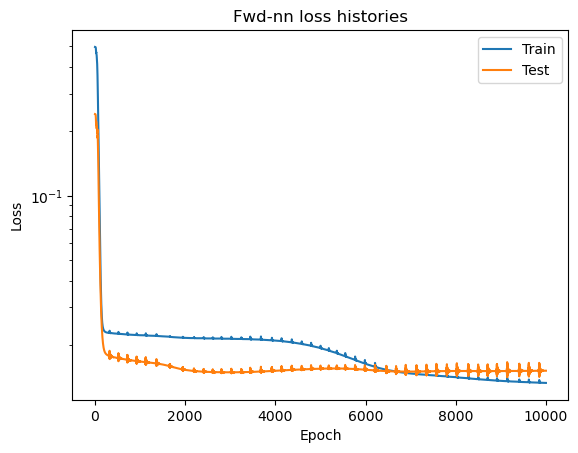

In [10]:
# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test']);
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.title('Fwd-nn loss histories');
#plt.savefig('Loss Histories.png')

In [11]:
def calculate_R2(true, pred):
    true_mean = true.mean()
    ss_tot = ((true-true_mean)**2).sum()
    ss_res = ((true-pred)**2).sum()
    return 1. - (ss_res/ss_tot)

def plotR2_strainenergy(true, pred):
    num_of_figs = true.shape[1]
    fig = plt.figure(figsize=(15,15))
    def helper(ax,index):
        R2 = calculate_R2(true[:,index].squeeze().numpy(), pred[:,index].squeeze().detach().numpy())
        R2 = np.round(R2,2)
        ax.scatter(true[:,index], pred[:,index].detach())
        ax.plot([0,true[:,index].max()],[0,true[:,index].max()],c='red')
        ax.set_title('W: {},  R2={}'.format(index,R2))
        ax.set_xlabel('True'); ax.set_ylabel('Predicted')
    for i in range(num_of_figs):
        ax = fig.add_subplot(3, 3, i+1)
        helper(ax,i)
    #plt.savefig('R2.png')
    fig.tight_layout()

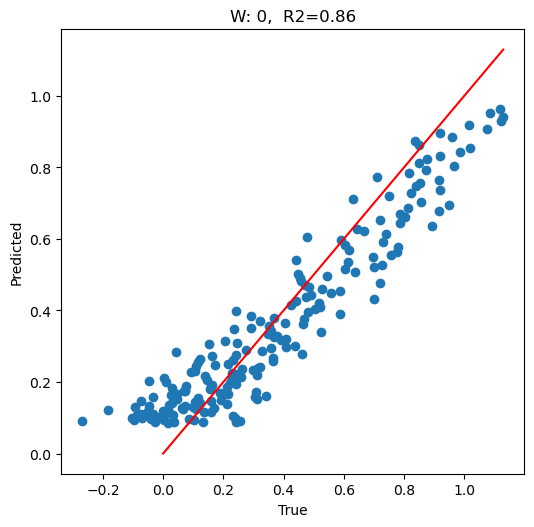

In [12]:
with torch.no_grad():
    y_test_pred = icnn(x_test)

# Visualize accuracy
plotR2_strainenergy(y_test, y_test_pred)

In [13]:
F11_test = x_test[:, 0].numpy()
F12_test = x_test[:, 1].numpy()
F13_test = x_test[:, 2].numpy()
F21_test = x_test[:, 3].numpy()
F22_test = x_test[:, 4].numpy()
F23_test = x_test[:, 5].numpy()
F31_test = x_test[:, 6].numpy()
F32_test = x_test[:, 7].numpy()
F33_test = x_test[:, 8].numpy()

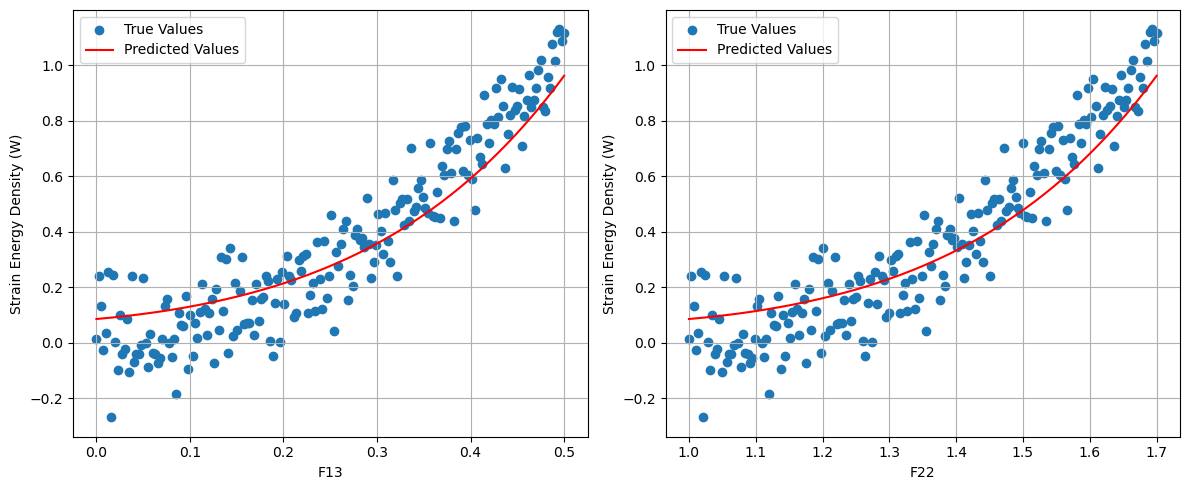

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axs[0].scatter(F13_test, y_test, label='True Values')
axs[0].plot(F13_test, y_test_pred, label='Predicted Values', color='r')
axs[0].set_xlabel('F13')
axs[0].set_ylabel('Strain Energy Density (W)')
axs[0].legend()
axs[0].grid(True)

# Plot for F22
axs[1].scatter(F22_test, y_test, label='True Values')
axs[1].plot(F22_test, y_test_pred, label='Predicted Values', color='r')
axs[1].set_xlabel('F22')
axs[1].set_ylabel('Strain Energy Density (W)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_pred.png')

# Show combined plot
plt.show()

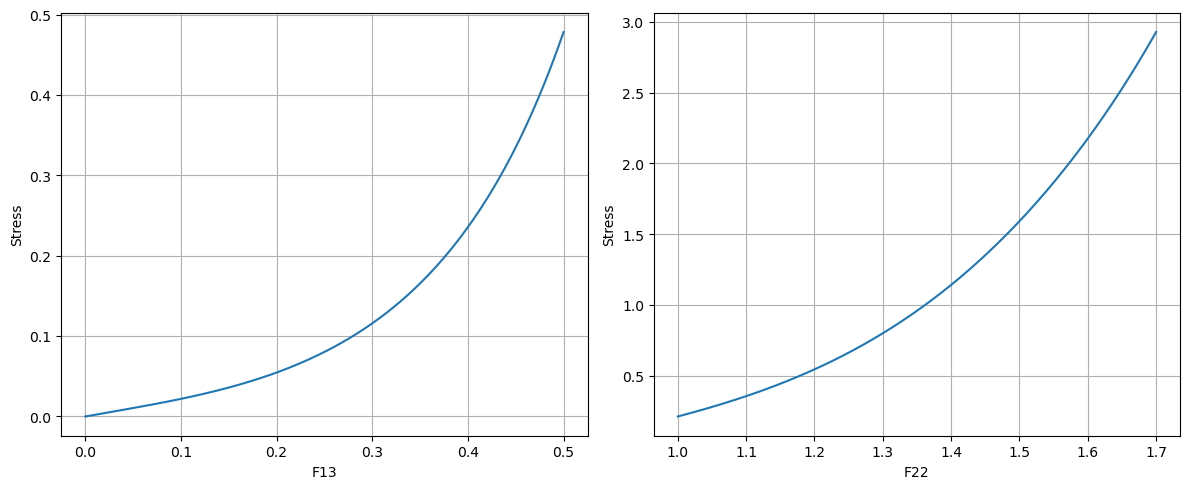

In [15]:
# Compute the gradient of the predicted values with respect to the input on F13 and F22 and plot it
x_test.requires_grad = True
y_test_pred = icnn(x_test)
y_test_pred.backward(torch.ones_like(y_test_pred))
grad = x_test.grad

#Combine the above two plots using subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axs[0].plot(F13_test, grad[:, 2].detach().numpy())
axs[0].set_xlabel('F13')
axs[0].set_ylabel('Stress')
axs[0].grid(True)

# Plot for F22
axs[1].plot(F22_test, grad[:, 4].detach().numpy())
axs[1].set_xlabel('F22')
axs[1].set_ylabel('Stress')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_gradient.png')

# Show combined plot
plt.show()

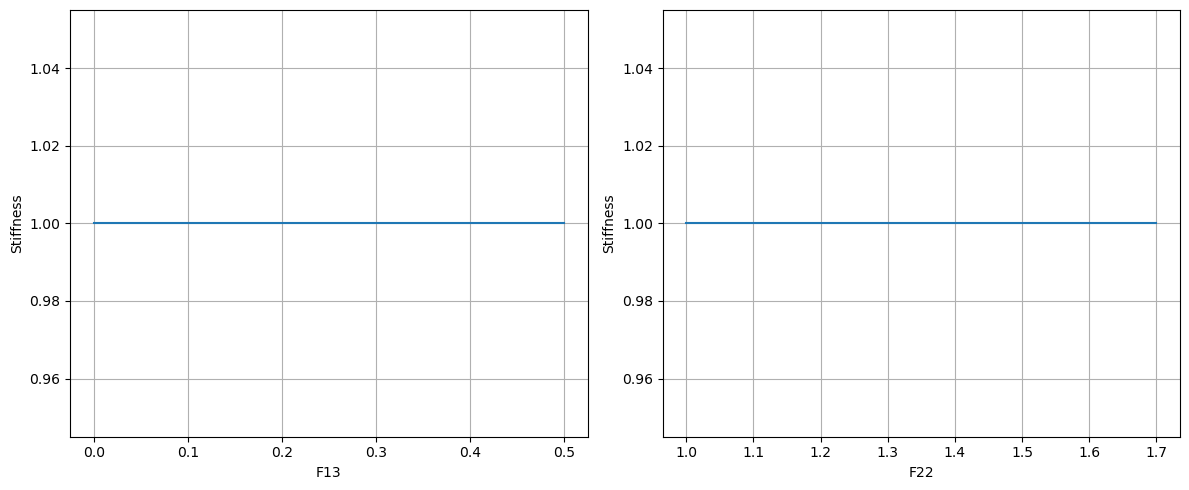

In [16]:
#Compute the 2nd derivative of the predicted values with respect to the input on F13 and F22 and plot it
x_test.requires_grad = True
y_test_pred = icnn(x_test)
y_test_pred.backward(torch.ones_like(y_test_pred), retain_graph=True)
grad = x_test.grad
grad = grad.detach()
grad.requires_grad = True
grad.backward(torch.ones_like(grad))
grad2 = grad.grad

#Combine above two plots using subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot for F13
axs[0].plot(F13_test, grad2[:, 2].detach().numpy())
axs[0].set_xlabel('F13')
axs[0].set_ylabel('Stiffness')
axs[0].grid(True)

# Plot for F22
axs[1].plot(F22_test, grad2[:, 4].detach().numpy())
axs[1].set_xlabel('F22')
axs[1].set_ylabel('Stiffness')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save combined plot
#plt.savefig('combined_2nd_derivative.png')

# Show combined plot
plt.show()


In [17]:
#Check if all the value of grad2 is a constant and print a statement saying if or not it is constant
if torch.all(grad2[:, 2] == grad2[:, 2][0]) and torch.all(grad2[:, 4] == grad2[:, 4][0]):
    print('The 2nd derivative of W with respect to F13 and F22 is a constant')
else:
    print('The 2nd derivative of W with respect to F13 and F22 |is not a constant')

The 2nd derivative of W with respect to F13 and F22 is a constant
